# Synthetic VNF Data

Gen synth data and fit multiple models agains it

In [18]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.base import BaseEstimator
from sklearn.model_selection import KFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

%matplotlib inline

sns.set(font_scale=3, style="white")

In [19]:
class FixedModel(BaseEstimator):
    """
    sklearn model of the fixed model, 
    always allocating/predicting a fixed, pre-defined amount of resources.
    For use in sklearn functions like k-fold CV
    """
    def __init__(self, fixed_value):
        self.fixed_value = fixed_value
        
    def fit(self, X, y):
        """There's nothing to fit here"""
        return self
    
    def predict(self, X):
        """Always 'predict' the specified fixed value"""
        n_samples = X.shape[0]
        return [self.fixed_value for _ in range(n_samples)]

In [20]:
# define column names
cpu_col = 'Resource req. [e.g., CPU]'
thr_col = 'Traffic load [e.g., Mbit/s]'

In [21]:
# generate synthetic data
def gen_benchmark(cpu, coeff1=1, coeff2=1):
    """Generate max throughput for given CPU time according to log function"""
    return coeff1 * math.log2(1 + coeff2 * cpu)

def synthetic_benchmark():
    """Generate synthetic benchmark results for CPU time 0-100%"""
    cpu_list = np.arange(0.1, 1, .01)
    data = []
    for cpu in cpu_list:
        data.append([cpu, gen_benchmark(cpu, coeff2=100)])
    return pd.DataFrame(data, columns=[cpu_col, thr_col])

# inverse function to calculate cpu given a throughput
def inverse(thru, coeff2=1):
    return (1/coeff2) * (2**thru - 1)

In [33]:
# prepare data
df = synthetic_benchmark()
X = df[[thr_col]].values
y = df[cpu_col].values

In [37]:
z = df[[thr_col]]
z

,"Traffic load [e.g., Mbit/s]"
0,3.459432
1,3.584963
2,3.700440
3,3.807355
4,3.906891
...,...
85,6.584963
86,6.599913
87,6.614710
88,6.629357


In [23]:
def cross_validation_rmse(model, X, y, k=5, save_model=False):
    """Do k-fold CV and return the avg RMSE on the validation set. Train and save the model."""
    scores = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=k)
    rmse = np.sqrt(-scores)
    name = type(model).__name__
    print(f"CV RMSE of {name}: {rmse.mean()} (+/-{rmse.std()})")  
    if save_model:
        model.fit(X, y)
        joblib.dump(model, f'ml_models/synth_data/{name}.joblib')
    return rmse 

def barplot_rmse(scores, labels, data_name):
    """bar plot comparing the RMSE of the different algorithms"""
    assert len(scores) == len(labels)
    
    # preparation
    rmse_mean = [s.mean() for s in scores]
    rmse_std = [s.std() for s in scores]
    x = np.arange(len(labels))

    # plot
    fig, ax = plt.subplots(figsize = (8, 6))
    plt.barh(x, rmse_mean, color='grey', xerr=rmse_std, capsize=5)

    # labels
    ax.set_xlabel('RMSE')
    ax.set_yticks(x)
    ax.set_yticklabels(labels)
    
    fig.savefig(f'plots/{data_name}_rmse.pdf', bbox_inches='tight')

CV RMSE of LinearRegression: 0.12121162713679345 (+/-0.08341424205714895)
CV RMSE of Ridge: 0.11570830365535674 (+/-0.07204672163128782)
CV RMSE of SVR: 0.17064460635337564 (+/-0.11301560222059377)
CV RMSE of RandomForestRegressor: 0.07869607909217609 (+/-0.02904883478187377)
CV RMSE of GradientBoostingRegressor: 0.07767855702267787 (+/-0.025005354888196104)
CV RMSE of MLPRegressor: 0.2708817420739588 (+/-0.11500216639809152)
CV RMSE of FixedModel: 0.30476112171679437 (+/-0.19909124881970067)


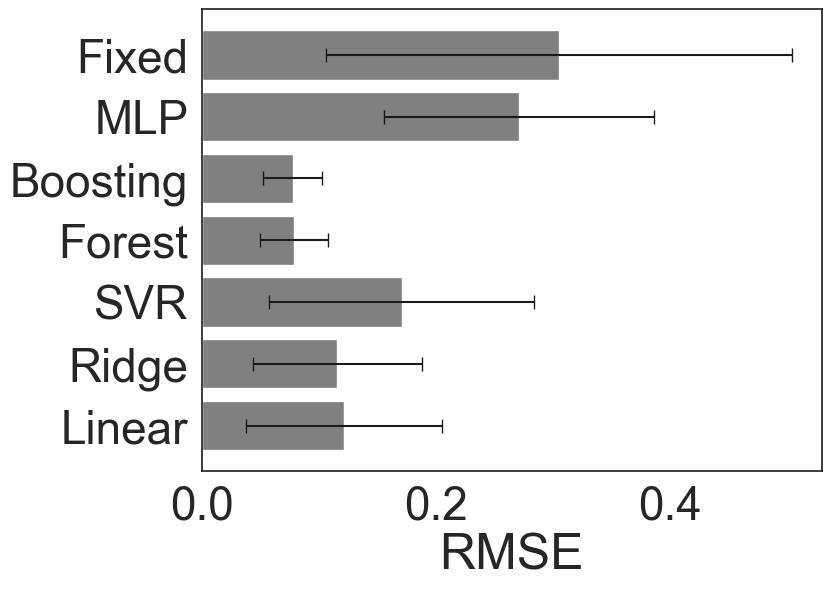

In [24]:
models = [LinearRegression(), Ridge(), SVR(), RandomForestRegressor(), 
          GradientBoostingRegressor(), MLPRegressor(max_iter=1500), 
          FixedModel(fixed_value=0.8)]
labels = ['Linear', 'Ridge', 'SVR', 'Forest', 'Boosting', 'MLP', 'Fixed']
rmse = [cross_validation_rmse(model, X, y) for model in models]

barplot_rmse(rmse, labels, 'synth_default')

CV RMSE of LinearRegression: 0.12121162713679337 (+/-0.08341424205714894)
CV RMSE of Ridge: 0.09668457215749979 (+/-0.060822156542014644)
CV RMSE of SVR: 0.1706446063533756 (+/-0.11301560222059376)
CV RMSE of RandomForestRegressor: 0.07873600046175809 (+/-0.028327360314669283)
CV RMSE of GradientBoostingRegressor: 0.07767855702267787 (+/-0.025005354888196104)
CV RMSE of MLPRegressor: 0.17788137184482244 (+/-0.1202044307560281)
CV RMSE of FixedModel: 0.30476112171679437 (+/-0.19909124881970067)


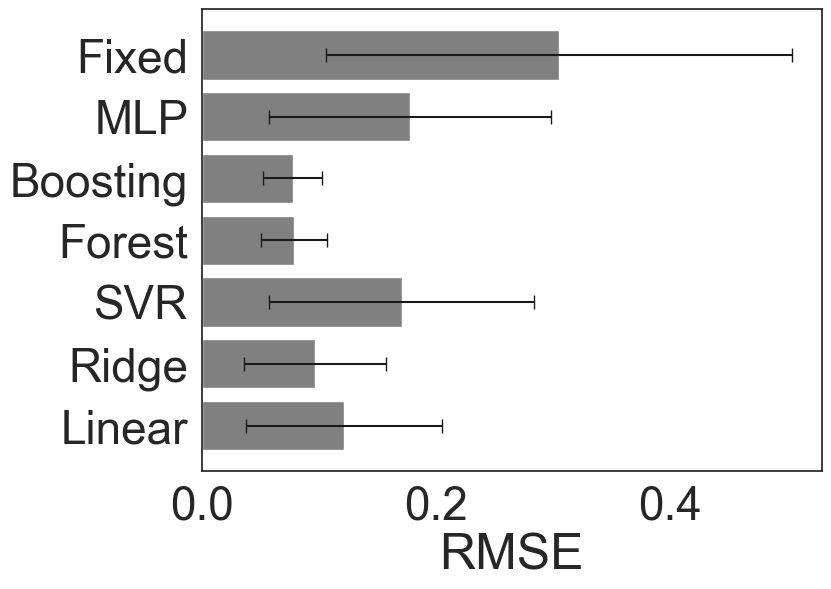

In [25]:
# scale the data and do again
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
os.makedirs(f'ml_models/synth_data', exist_ok=True)
joblib.dump(scaler, f'ml_models/synth_data/scaler.joblib')

rmse = [cross_validation_rmse(model, X_scaled, y) for model in models]
barplot_rmse(rmse, labels, 'synth_scaled')

In [26]:
def tune_hyperparams(model, X, y, params):
    """Do grid search CV for hyperparam tuning and return CV RMSE"""
    grid_search = GridSearchCV(model, params, cv=5, scoring="neg_mean_squared_error")
    grid_search.fit(X, y)   
    return grid_search.best_estimator_

CV RMSE of LinearRegression: 0.12121162713679337 (+/-0.08341424205714894)
CV RMSE of Ridge: 0.09668457215749979 (+/-0.060822156542014644)
CV RMSE of SVR: 0.026393013794688152 (+/-0.015803492947378504)
CV RMSE of RandomForestRegressor: 0.07883073073257627 (+/-0.02845435141397823)
CV RMSE of GradientBoostingRegressor: 0.07750966610011184 (+/-0.02516349460330408)
CV RMSE of MLPRegressor: 0.09441090755402924 (+/-0.0693418669738098)
CV RMSE of FixedModel: 0.30476112171679437 (+/-0.19909124881970067)


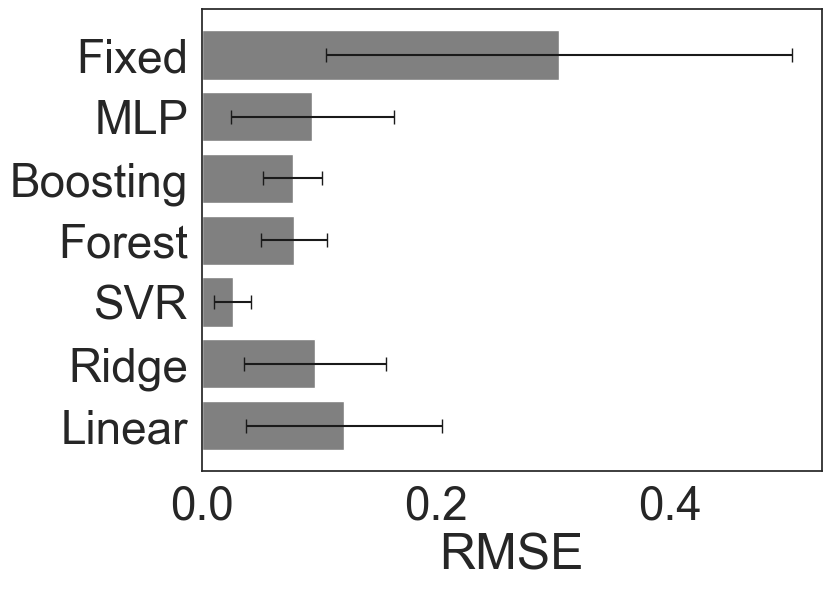

In [27]:
# hyperparam tuning
params_ridge = {'alpha': [0.1, 1, 10]}
params_svr = {'kernel': ['linear', 'poly', 'rbf'], 'C': [1, 10, 100], 
              'epsilon': [0.001, 0.01, 0.1]}
params_forest = {'n_estimators': [10, 100, 200]}
params_boosting = {'learning_rate': [0.01, 0.1, 0.3], 'n_estimators': [10, 100, 200]}
params_mlp = {'hidden_layer_sizes': [(64,), (128,), (256)], 'alpha': [0.001, 0.0001, 0.00001],
              'learning_rate_init': [0.01, 0.001, 0.0001]}

params = [{}, params_ridge, params_svr, params_forest, params_boosting, params_mlp, {}]
models_tuned = [tune_hyperparams(models[i], X_scaled, y, params[i]) for i in range(len(models))]
rmse_tuned = [cross_validation_rmse(model, X_scaled, y, save_model=True) for model in models_tuned]

barplot_rmse(rmse_tuned, labels, 'synth_tuned')

In [35]:
# plot
sns.set(font_scale=1, style="white")

def plot_predictions(models, labels, X, y):
    assert len(models) == len(labels)
    
    fig, ax = plt.subplots()
    plt.plot(X, y, label='True', color='black', linewidth=2)
    
    for i in range(len(models)):
        models[i].fit(X, y)
        plt.plot(X, models[i].predict(X), label=labels[i])

    plt.xlabel(thr_col)
    plt.ylabel(cpu_col)
    plt.ylim(0, 1)
    plt.legend()

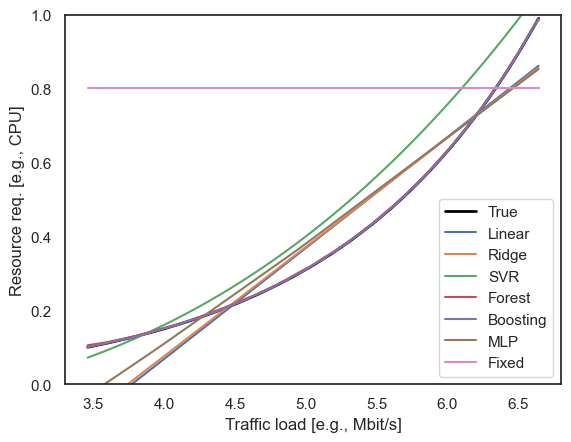

In [36]:
plot_predictions(models_tuned, labels, X, y)

In [30]:
X

array([[3.45943162],
       [3.5849625 ],
       [3.70043972],
       [3.80735492],
       [3.9068906 ],
       [4.        ],
       [4.08746284],
       [4.169925  ],
       [4.24792751],
       [4.32192809],
       [4.39231742],
       [4.45943162],
       [4.52356196],
       [4.5849625 ],
       [4.64385619],
       [4.70043972],
       [4.7548875 ],
       [4.80735492],
       [4.857981  ],
       [4.9068906 ],
       [4.95419631],
       [5.        ],
       [5.04439412],
       [5.08746284],
       [5.12928302],
       [5.169925  ],
       [5.20945337],
       [5.24792751],
       [5.28540222],
       [5.32192809],
       [5.357552  ],
       [5.39231742],
       [5.42626475],
       [5.45943162],
       [5.4918531 ],
       [5.52356196],
       [5.55458885],
       [5.5849625 ],
       [5.61470984],
       [5.64385619],
       [5.67242534],
       [5.70043972],
       [5.72792045],
       [5.7548875 ],
       [5.78135971],
       [5.80735492],
       [5.83289001],
       [5.857